In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import pandas as pd
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3

In [ ]:
import os

# Set the directories containing the images and masks
# image_dir = '/content/drive/MyDrive/training_sets_new/Set6/X_train'
# mask_dir = '/content/drive/MyDrive/training_sets_new/Set6/Y_train'

image_dir = '/content/drive/MyDrive/Input'
mask_dir = '/content/drive/MyDrive/Manual_thresholding'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)



In [ ]:
image_x = random.randint(0, 59)
image_x

17

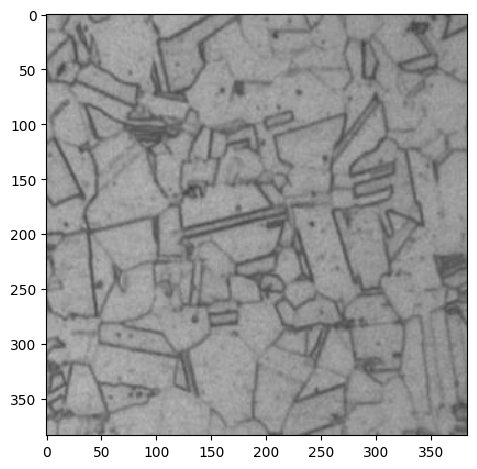

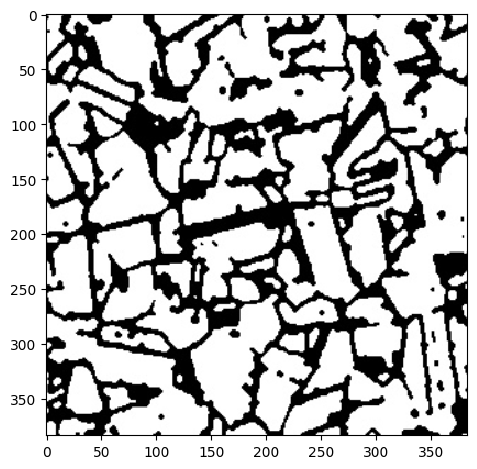

In [ ]:
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()


In [ ]:
#Build the model

inputs = tf.keras.layers.Input((None, None, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 16) │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, None, 16) │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 16) │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 16) │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 32) │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, None, 32) │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 32) │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, None, None, 32) │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None, 64) │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, None, 64) │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, None, None, 64) │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, None, None, 64) │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, None, None,     │         73,856 │ max_pooling2d_2[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, None,     │              0 │ conv2d_6[0][0]         │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, None, None,     │        147,584 │ dropout_3[0][0]        │
│                      

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)

# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)



In [ ]:
X_train.shape

(60, 384, 384, 3)

In [ ]:
#convert the boolean where it is true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimension RGB to just one boolean value

Y_t= np.any(Y_train, axis=-1)
Y_t = Y_t.reshape(60, 384, 384, 1)

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_images = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection) / (sum_images + 1e-8)  # Adding a small value to avoid division by zero
    return dice

In [ ]:
"""def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_images = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection) / (sum_images + 1e-8)  # Adding a small value to avoid division by zero
    return dice"""

'def dice_coefficient(y_true, y_pred):\n    intersection = tf.reduce_sum(y_true * y_pred)\n    sum_images = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)\n    dice = (2. * intersection) / (sum_images + 1e-8)  # Adding a small value to avoid division by zero\n    return dice'

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', dice_coefficient])

callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Assuming X_train and Y_t are your training data and labels respectively
results = model.fit(X_train, Y_t, validation_split=0.05, batch_size=8, epochs=1000, callbacks=callbacks)


Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4940 - dice_coefficient: 0.4986 - loss: 0.8085 - val_accuracy: 0.4963 - val_dice_coefficient: 0.5588 - val_loss: 0.6731
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.5649 - dice_coefficient: 0.5899 - loss: 0.6693 - val_accuracy: 0.4968 - val_dice_coefficient: 0.5697 - val_loss: 0.6638
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5801 - dice_coefficient: 0.5958 - loss: 0.6573 - val_accuracy: 0.5177 - val_dice_coefficient: 0.5985 - val_loss: 0.6460
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6681 - dice_coefficient: 0.6130 - loss: 0.6158 - val_accuracy: 0.5108 - val_dice_coefficient: 0.6677 - val_loss: 0.7742
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6216 - dice_coefficient: 0.6502 - loss: 0.6738 - val_accuracy: 0.6622 - val_dice_coefficient: 0.6602 - val_loss: 0.5628
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7146 

In [ ]:
#model.save_weights('/content/drive/MyDrive/training_sets/Set1/Ep100.h5')

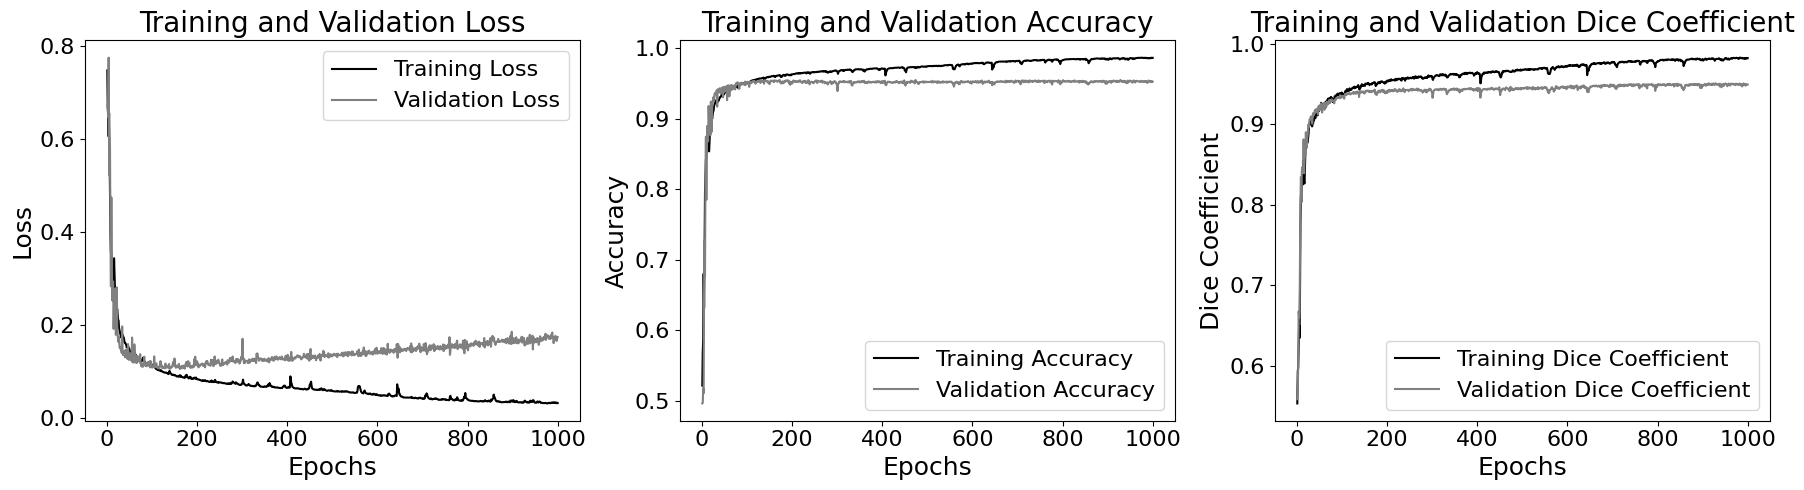

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs to plot

num_epochs = 1000

# Extracting metrics
train_loss = results.history['loss'][:num_epochs]
val_loss = results.history['val_loss'][:num_epochs]
train_acc = results.history['accuracy'][:num_epochs]
val_acc = results.history['val_accuracy'][:num_epochs]
train_dice = results.history['dice_coefficient'][:num_epochs]
val_dice = results.history['val_dice_coefficient'][:num_epochs]
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, 'k', label='Training Loss')
plt.plot(epochs, val_loss, 'gray', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_acc, 'k', label='Training Accuracy')
plt.plot(epochs, val_acc, 'gray', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

# Plotting training and validation dice coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, train_dice, 'k', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'gray', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Dice Coefficient', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()



In [ ]:
####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)


2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


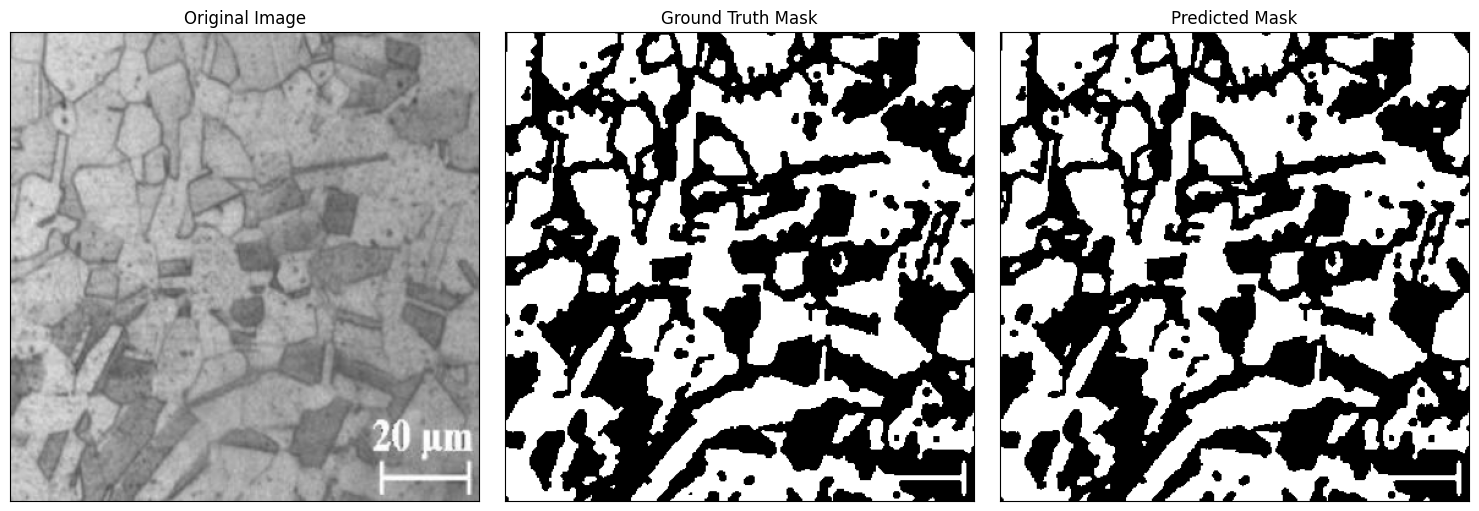

In [ ]:
import random
import matplotlib.pyplot as plt

# Assuming X_train[ix], Y_t[ix], preds_train_t[ix] are numpy arrays

# Generate random index
ix = random.randint(0, len(preds_train_t))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axes[0].imshow(X_train[ix])
axes[0].set_title('Original Image')

# Plot ground truth mask (binary)
axes[1].imshow(Y_t[ix], cmap='gray')
axes[1].set_title('Ground Truth Mask')

# Plot predicted mask (binary)
axes[2].imshow(preds_train_t[ix], cmap='gray')
axes[2].set_title('Predicted Mask')

# Remove ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the plots
plt.tight_layout()
plt.show()


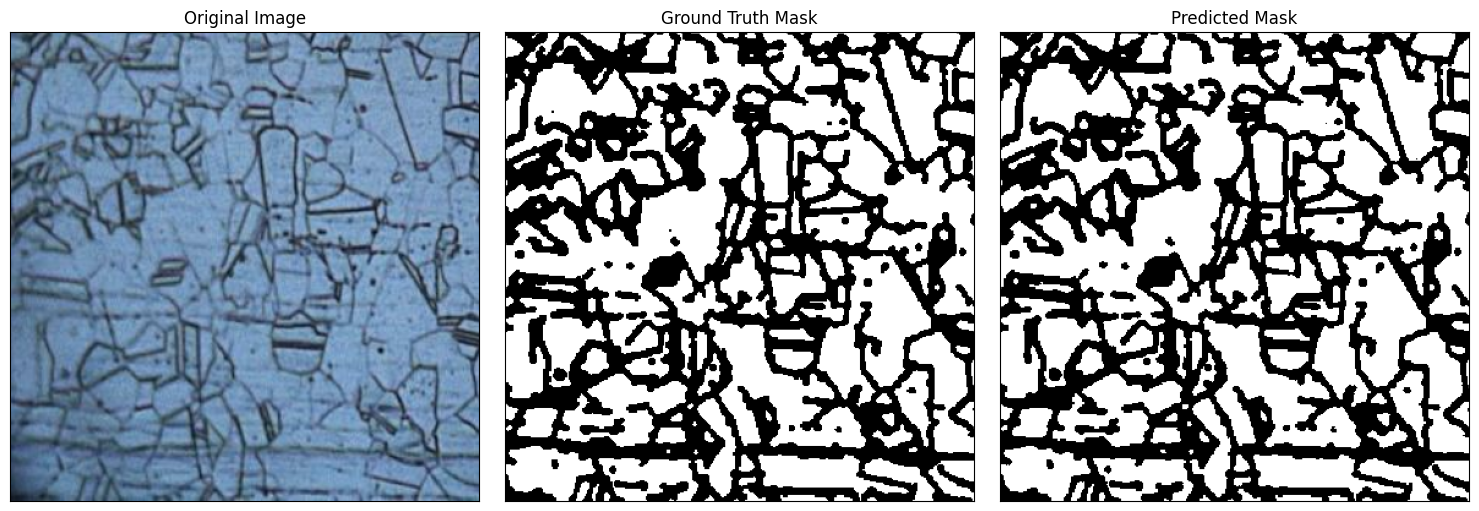

In [ ]:
import random
import matplotlib.pyplot as plt

# Assuming imshow() and plot() functions are defined elsewhere

# Generate random index
ix = random.randint(0, len(preds_val_t))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axes[0].imshow(X_train[int(X_train.shape[0]*0.9):][ix])
axes[0].set_title('Original Image')

# Plot ground truth mask (binary)
axes[1].imshow(Y_t[int(Y_train.shape[0]*0.9):][ix], cmap='gray')
axes[1].set_title('Ground Truth Mask')

# Plot predicted mask (binary)
axes[2].imshow(preds_val_t[ix], cmap='gray')
axes[2].set_title('Predicted Mask')

# Remove ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Display the plots
plt.tight_layout()
plt.show()







In [ ]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Load the trained model from the checkpoint
# # checkpoint_path = '/content/drive/MyDrive/training_sets/Set2/checkpoint_path/GrainsTraining.ckpt'  # Specify your checkpoint path
# # model = tf.keras.models.load_model(checkpoint_path)

# # Specify the folder path containing the images to be tested
# test_folder_path = '/content/drive/MyDrive/training_sets/Set2/final_input/'

# # Specify the folder path to save the predictions
# predictions_folder_path = '/content/drive/MyDrive/training_sets/Set2/predictions/'

# # Create the predictions folder if it doesn't exist
# os.makedirs(predictions_folder_path, exist_ok=True)

# # Function to preprocess images
# def preprocess_image(image_path):
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, (384, 384))  # Adjust the desired width and height
#     return image

# # Iterate through each image in the test folder
# for image_name in os.listdir(test_folder_path):
#     # Load and preprocess the image
#     image_path = os.path.join(test_folder_path, image_name)
#     image = preprocess_image(image_path)
#     image = np.expand_dims(image, axis=0)  # Add batch dimension

#     # Make predictions
#     predictions = model.predict(image)

#     # Plot the image and its prediction
#     plt.imshow(image[0])
#     plt.title(f'Image: {image_name}')
#     # Uncomment below lines once you have model predictions
#     plt.figure()
#     plt.imshow(predictions[0])
#     plt.title('Prediction')
#     plt.show()

#     # Save the predictions as JPEG images
#     prediction_image = predictions[0]   # Scale the prediction to 0-255 range
#     prediction_image_path = os.path.join(predictions_folder_path, image_name)
#     cv2.imwrite(prediction_image_path, prediction_image)
# print("Predictions saved successfully as JPEG images.")


In [ ]:
# import numpy as np
# import cv2
# import os

# def dice_coefficient(image1, image2):
#     intersection = np.sum(image1 * image2)
#     sum_images = np.sum(image1) + np.sum(image2)
#     dice = (2. * intersection) / (sum_images + 1e-8)  # Adding a small value to avoid division by zero
#     return dice

# def load_image(image_path):
#     return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# def convert_to_binary(arr, threshold=128):
#     return (arr >= threshold).astype(np.uint8)

# def calculate_average_dice(folder1, folder2):
#     # List all images in the folders
#     images1 = sorted(os.listdir(folder1))
#     images2 = sorted(os.listdir(folder2))

#     total_dice = 0
#     num_images = len(images1)  # Assuming both folders have the same number of images

#     for img1, img2 in zip(images1, images2):
#         # Load images
#         image1 = load_image(os.path.join(folder1, img1))
#         image2 = load_image(os.path.join(folder2, img2))

#         # Convert images to binary
#         image1_binary = convert_to_binary(image1, threshold=128)
#         image2_binary = convert_to_binary(image2, threshold=128)

#         # Calculate Dice coefficient
#         dice_score = dice_coefficient(image1_binary, image2_binary)
#         total_dice += dice_score

#     average_dice = total_dice / num_images
#     return average_dice * 100  # Convert to percentage

# # Example usage:
# folder1 = "/content/drive/MyDrive/training_sets/Set1/final_output"  # Path to the first folder containing images
# folder2 = "/content/drive/MyDrive/training_sets/Set1/final_manual_segmented"  # Path to the second folder containing corresponding ground truth images

# average_dice = calculate_average_dice(folder1, folder2)
# print("Average Dice coefficient:", average_dice)